In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torch import optim
import albumentations as A
import copy
from albumentations.pytorch import ToTensorV2

In [2]:
DEVICE = 'cuda' 
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = 'data_cancer/' 

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [5]:
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transforms)
valid_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def train_model(train_loader, val_loader, device='cuda'):
    model = models.efficientnet_b0(weights='DEFAULT')
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # malignant/benign
    model.to(device)

    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

    early_stopping = EarlyStopping(patience=5)
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses, val_losses = [], []

    unfreeze_epoch = 3  
    for epoch in range(30):
        model.train()
        running_loss, running_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item()
            running_acc += (preds == labels).float().mean().item()

        train_loss = running_loss / len(train_loader)
        train_acc = running_acc / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)
                val_loss += loss.item()
                val_acc += (preds == labels).float().mean().item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_losses.append(val_loss)

        print(f"[{epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)
        early_stopping(val_loss)

        if val_loss < early_stopping.best_loss:
            best_model_wts = copy.deepcopy(model.state_dict())

        if early_stopping.early_stop:
            print("🛑 Early stopping triggered")
            break

        if epoch == unfreeze_epoch:
            print("🔓 Unfreezing all layers...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses


In [7]:
device = 'cuda' 
model, train_losses, val_losses = train_model(train_loader, valid_loader, device=device)

[0] Train Loss: 0.5017 | Val Loss: 0.4283 | Val Acc: 0.8048
[1] Train Loss: 0.4276 | Val Loss: 0.4031 | Val Acc: 0.8241
[2] Train Loss: 0.4244 | Val Loss: 0.3946 | Val Acc: 0.8241
[3] Train Loss: 0.4267 | Val Loss: 0.3988 | Val Acc: 0.8137
🔓 Unfreezing all layers...
[4] Train Loss: 0.3737 | Val Loss: 0.3223 | Val Acc: 0.8494
[5] Train Loss: 0.3233 | Val Loss: 0.2968 | Val Acc: 0.8667
[6] Train Loss: 0.2969 | Val Loss: 0.2949 | Val Acc: 0.8658
[7] Train Loss: 0.2870 | Val Loss: 0.2682 | Val Acc: 0.8771
[8] Train Loss: 0.2563 | Val Loss: 0.2554 | Val Acc: 0.8926
[9] Train Loss: 0.2497 | Val Loss: 0.2320 | Val Acc: 0.9009
[10] Train Loss: 0.2178 | Val Loss: 0.2392 | Val Acc: 0.9000
[11] Train Loss: 0.2394 | Val Loss: 0.2232 | Val Acc: 0.9009
[12] Train Loss: 0.2225 | Val Loss: 0.2132 | Val Acc: 0.9024
[13] Train Loss: 0.2089 | Val Loss: 0.2100 | Val Acc: 0.9051
[14] Train Loss: 0.2038 | Val Loss: 0.2095 | Val Acc: 0.9083
[15] Train Loss: 0.1869 | Val Loss: 0.2098 | Val Acc: 0.9009
[16] Tr

In [11]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, loader, device='cuda', class_names=None):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # class 1 probability (malignant)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_score = np.array(all_probs)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📊 Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc_val = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc_val:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


📊 Evaluation Metrics:
Accuracy:  0.8985
Precision: 0.8520
Recall:    0.9400
F1 Score:  0.8938
ROC AUC:   0.9765

Classification Report:
               precision    recall  f1-score   support

      benign       0.95      0.86      0.90       360
   malignant       0.85      0.94      0.89       300

    accuracy                           0.90       660
   macro avg       0.90      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660



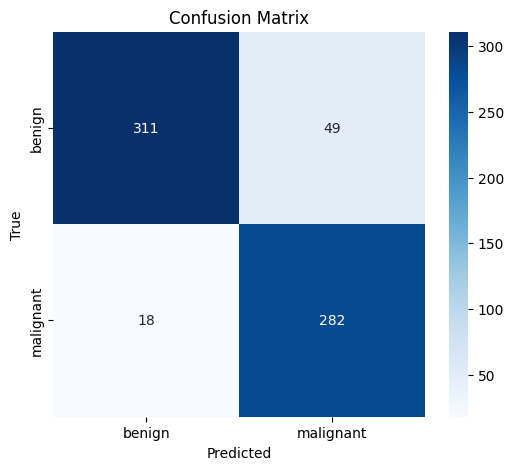

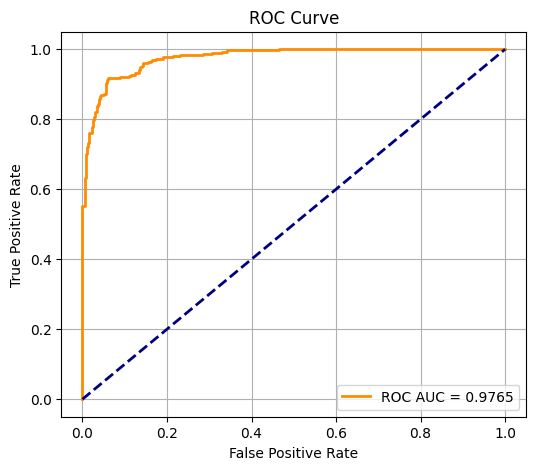

In [12]:
evaluate_model(model, valid_loader, device='cuda', class_names=train_dataset.classes)

In [10]:
torch.save(model.state_dict(), 'model.pth')